In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import clear_output
import os
import gzip
import shutil
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from natsort import natsort_keygen
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mattroth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Function to download genres dataset from UCSD source
def download_data(filename, new_filename):
   
    """
    Downloads raw goodreads data from UCSD 
    ______

    filename(str): name of the file as hosted by UCSD. e.g. "goodreads_books.json.gz"
    new_filename(str): how you want to save the file locally. e.g. "goodreads_books.json"
    """

    wd = os.getcwd()
    url = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/" + filename
        
    def download_by_name(fname, local_filename):

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
            
    output_path = os.path.join(wd, filename)
    download_by_name(filename, output_path)

    # Unzip and convert to json
    with gzip.open(filename, 'rb') as f_in:
        with open(new_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [3]:
# Read in select fields from long version of books table
wd = os.getcwd()
col_names = ["book_id","title","description","language_code","ratings_count"]
json_data = []
# download_data("goodreads_books.json.gz", "goodreads_books.json")
file_name = wd + "/goodreads_books.json"

with open(file_name, encoding='UTF-8') as f:
    i = 0
    for line in f:
        doc = json.loads(line)
        lst = [doc[col_names[i]] for i in range(len(col_names))]
        json_data.append(lst)
        if i % 50000 == 0:
            clear_output(wait=True)
            print(f"Processing row: {i:,d}")
        i += 1
    print(f"Completed! Processed {i:,d} rows")

df_book_descriptions = pd.DataFrame(data=json_data, columns=col_names)

# Remove files
os.remove(wd + "/goodreads_books.json")
# os.remove(wd + "/goodreads_books.json.gz")

Processing row: 2,350,000
Completed! Processed 2,360,655 rows


In [4]:
df_book_descriptions.head()

,book_id,title,description,language_code,ratings_count
0,5333265,W.C. Fields: A Life on Film,,,3
1,1333909,Good Harbor,"Anita Diamant's international bestseller ""The ...",,10
2,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,eng,140
3,6066819,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,eng,51184
4,287140,Runic Astrology: Starcraft and Timekeeping in ...,,,15


In [5]:
# Get rid of null descriptions
df_book_descriptions = df_book_descriptions[df_book_descriptions["description"] != ""]

# Filter out books with less than 100 ratings
df_book_descriptions['ratings_count'] = pd.to_numeric(
                                                df_book_descriptions["ratings_count"], errors='coerce'
                                            ).astype('Int32')
df_book_descriptions = df_book_descriptions[df_book_descriptions["ratings_count"] > 100]

# Keep only english or null language books
df_book_descriptions = df_book_descriptions[df_book_descriptions["language_code"]\
                            .isin(["","eng","en-US","en-GB","en-CA"])]

# Cut down to just id, title, and description
df_book_descriptions = df_book_descriptions[["book_id", "title", "description"]]
df_book_descriptions.head()

,book_id,title,description
2,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...
3,6066819,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...
9,287149,The Devil's Notebook,"Wisdom, humor, and dark observations by the fo..."
10,6066814,"Crowner Royal (Crowner John Mystery, #13)","London, 1196. At the command of Richard the Li..."
15,89375,90 Minutes in Heaven: A True Story of Death an...,As he is driving home from a minister's confer...


In [8]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(
    "(?:(?<=\s)|(?<=^)|(?<=[>\"]))[a-z-']+(?:(?=\s)|(?=\:\s)|(?=$)|(?=[.!,;\"]))"
)

# Lemmatize description text
lem = WordNetLemmatizer()
def lemmatize_text(text):
    return [lem.lemmatize(w) for w in tokenizer.tokenize(text)]

# Add lemmatized version of description to df_book_descriptions
df_book_descriptions['description_lemmatized'] = df_book_descriptions["description"]\
                                                    .apply(lambda x: lemmatize_text(x))
df_book_descriptions["description_lemmatized"] = df_book_descriptions["description_lemmatized"]\
                                                    .apply(lambda x: " ".join(x))

# Create custom stop words set with units and others
custom_stop_words = text.ENGLISH_STOP_WORDS.union([
    "ha","wa","-","--","u","life","he's","she's","didn't","doesn't","don't","can't","le","who's",
    "isn't","wasn't","they're", "man","woman","mom","dad","mother","father","brother","sister",
    "son","daughter","girl","boy","character","story","novel","book","author","edition","new",
    "reader",'want','thing','like','make','need',"it's","know","come", 'work','writer','volume',
    'published','series','tale','original','wanted','knew','met','love','got','thought','just',
    'away','did','la','en','y','que','el','los','su','una','del','se','e','o','na','da','di','se',
    'v','la','je','si','s,','t','s', 'et', 'il', 'sa', 'ne', 'du', 'che', 'qui', 'une', 'ce',
    'mn','fy','w',"'n",'l','m','min','lktb','lty','und','der','er','sie','den','von','zu',
    'por','para','ma','como','al','sus','lo','vida','esta','historia',","
    ])

# Encode data with TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=list(custom_stop_words),
                        max_df=0.6, # ignore words occuring in more than this % of docs
                        min_df=0.0005, # ignore words occuring in less than this % of docs
                        max_features=8000,
                        tokenizer=tokenizer.tokenize)
vectorized_descriptions = tfidf.fit_transform(df_book_descriptions["description_lemmatized"])

# Save vocab
vocab = tfidf.get_feature_names_out()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
# Instantiate LDA
n_topics = 30
lda = LDA(n_components=n_topics, n_jobs=-1)

# Run on vectorized_descriptions
X_topics = lda.fit_transform(vectorized_descriptions)

In [10]:
# Get topic distribution
topic_words = lda.components_

# Retrieve topics
genre_strings = []
for i, topic_dist in enumerate(topic_words):
    
    # Zip vocab and topic distribution
    zipped_10 = zip(vocab, topic_dist)    

    # Sort and get out top 1 words for each topic for dict
    top_terms_key_10 = sorted(zipped_10, key=lambda t: t[1], reverse=True)[0:10]
    top_terms_list_10 = list(dict(top_terms_key_10).keys())

    # Print genre top words
    genre_string = f"Genre {i + 1}: {top_terms_list_10}"
    genre_strings.append(genre_string)
    print(genre_string)
    

Genre 1: ['family', 'world', 'young', 'time', 'year', 'voice', 'collection', 'child', 'human', 'moving']
Genre 2: ['game', 'player', 'team', 'baseball', 'sport', 'football', 'coach', 'play', 'win', 'basketball']
Genre 3: ['short', 'novella', 'prompt', 'photo', 'available', 'est', 'dans', 'novelette', 'pa', 'content']
Genre 4: ['vampire', 'world', 'demon', 'power', 'magic', 'witch', 'human', 'evil', 'werewolf', 'supernatural']
Genre 5: ['collection', 'classic', 'poem', 'fiction', 'text', 'introduction', 'includes', 'art', 'writing', 'short']
Genre 6: ['agent', 'mission', 'team', 'secret', 'terrorist', 'world', 'dangerous', 'enemy', 'government', 'spy']
Genre 7: ['music', 'film', 'movie', 'star', 'rock', 'band', 'fan', 'actor', 'television', 'career']
Genre 8: ['people', 'world', 'way', 'question', 'offer', 'guide', 'history', 'science', 'human', 'experience']
Genre 9: ['funny', 'hilarious', 'comic', 'humor', 'adventure', 'collection', 'comedy', 'witty', 'classic', 'fan']
Genre 10: ['ali

In [11]:
# Extract top topic for all descriptions
inferred_genres = lda.transform(vectorized_descriptions)

topics = []
for i in range(inferred_genres.shape[0]):

    # Get most likely topic for each descriptions
    topic = inferred_genres[i].argmax() + 1
    topics.append(topic)

# Add columns to df_book_descriptions
df_book_descriptions["main_genre"] = topics
for i in range(inferred_genres.shape[1]):
    df_book_descriptions[f"Genre_{i+1}"] = inferred_genres[:,i]

# Inspect df_book_descriptions with topic
df_book_descriptions.head()    

,book_id,title,description,description_lemmatized,main_genre,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,...,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25,Genre_26,Genre_27,Genre_28,Genre_29,Genre_30
2,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,book club edition containing the of and the of,17,0.013880,0.013880,0.013880,0.013880,0.013880,...,0.013880,0.013880,0.278813,0.013880,0.013880,0.013880,0.013880,0.013880,0.013880,0.013880
3,6066819,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,and were eight when they first met and decided...,19,0.005245,0.005245,0.005245,0.005245,0.005245,...,0.005245,0.005245,0.005245,0.005245,0.005245,0.005245,0.005245,0.005245,0.005245,0.005245
9,287149,The Devil's Notebook,"Wisdom, humor, and dark observations by the fo...",humor and dark observation by the founder of t...,8,0.007370,0.007370,0.007370,0.007370,0.007370,...,0.007370,0.007370,0.007370,0.007370,0.007370,0.007370,0.007370,0.007370,0.007370,0.007370
10,6066814,"Crowner Royal (Crowner John Mystery, #13)","London, 1196. At the command of Richard the Li...",the command of the de ha left his beloved for ...,29,0.004803,0.004803,0.004803,0.004803,0.004803,...,0.004803,0.004803,0.004803,0.320925,0.004803,0.004803,0.004803,0.004803,0.544578,0.004803
15,89375,90 Minutes in Heaven: A True Story of Death an...,As he is driving home from a minister's confer...,he is driving home from a minister's conferenc...,28,0.005006,0.005006,0.005006,0.005006,0.005006,...,0.005006,0.005006,0.005006,0.005006,0.005006,0.005006,0.005006,0.854832,0.005006,0.005006


In [15]:
# Save as csv
df_book_descriptions_short = df_book_descriptions.drop(["description", "description_lemmatized","title"], axis=1)
pd.DataFrame(genre_strings,columns=["genre_string"])\
                .to_csv(wd + "/data/inferred_genre_top_words.csv", index=False)
df_book_descriptions_short.to_csv(wd + "/data/inferred_genres.csv", index=False)

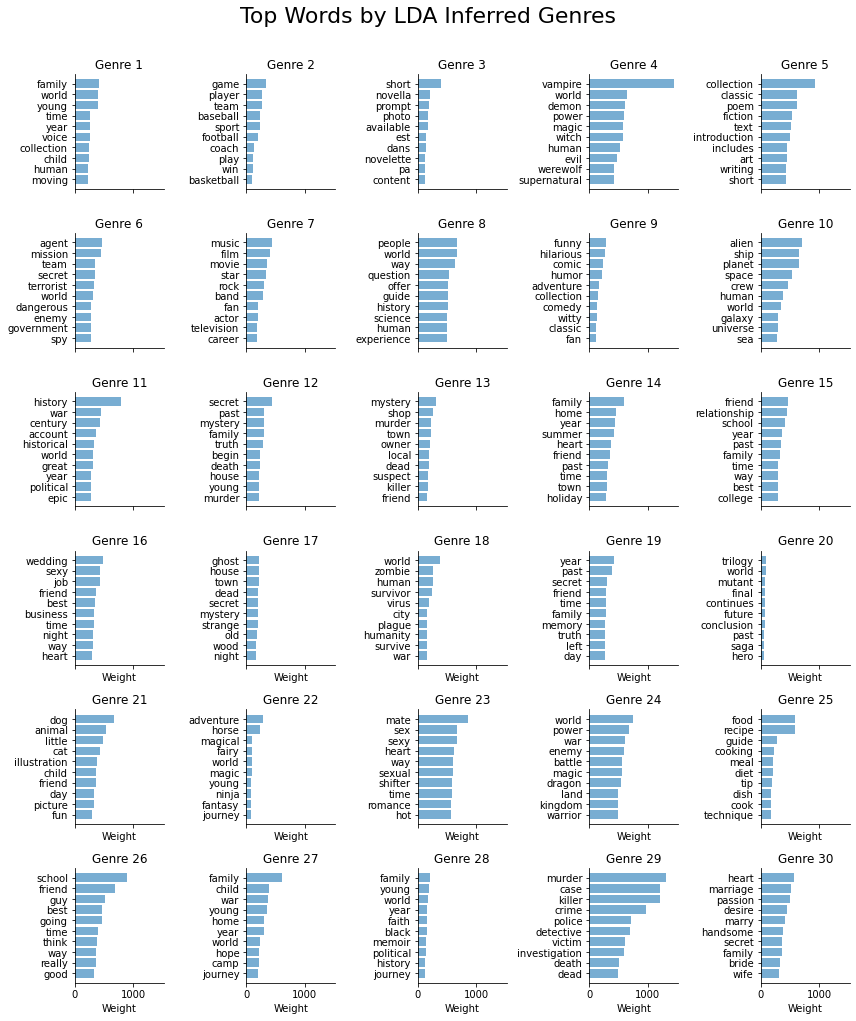

In [13]:
# Function to plot word importances to topics
def plot_top_words(model, feature_names):
    
    fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 14), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -10 - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, alpha=0.6)
        ax.set_title(f"Genre {topic_idx +1}")
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major")
        for i in "top right".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Top Words by LDA Inferred Genres", fontsize=22, y=1.01)
        if topic_idx >= 15:
            ax.set_xlabel("Weight")

    plt.tight_layout()
    plt.show()

plot_top_words(lda, vocab)

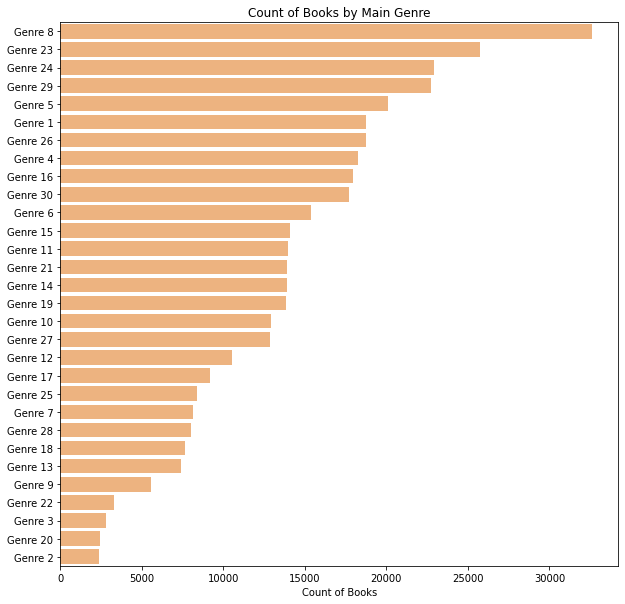

In [14]:
# Plot topics by number of books where each topic is the main topic
topic_count = df_book_descriptions.groupby("main_genre")["description"].count().reset_index()\
    .sort_values(by="description", ascending=False)
topic_count["topic_name"] = [f"Genre {t}" for t in topic_count["main_genre"]]

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(
    data=topic_count,
    y="topic_name",
    x="description",
    color="tab:orange",
    alpha=0.6
)
plt.ylabel(None)
plt.xlabel("Count of Books")
plt.title("Count of Books by Main Genre")
plt.show()